In [1]:
import pandas
import numpy as np
import sys, zipfile, os, time
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
warnings.filterwarnings('ignore')
sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 10),
         'axes.labelsize': 20,
         'axes.titlesize': 24,
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [3]:
def points(lon, lat, labels=None, values=None, markersize=80, ocean=True, land=True, coastlines=True, rivers=False,
           grid=True, posneg=False, extent=None, lloffset=0.2, showcost=False, clabel=None, cbars={}, colorlevels=None,
           data=None, vmin=None, vmax=None, dropna=False, figure=None, gridspecs=None, showalpha=1, showtitle=' ', **kwargs):
    """ Plot stations on a map

    Args:
        lon (np.array, list): Longitudes
        lat (np.array, list): Latidutes
        labels (np.array, list): Labels
        values (np.array, list): Values for scatterplot
        markersize (int): markersize
        ocean (bool): plot ocean ?
        land (bool): plot land ?
        coastlines (bool): plot coastlines ?
        rivers (bool): plot river ?
        grid (bool): plot gridlines ?
        posneg (bool): different markers for positive and negative
        extent (str): neither (default), both, min, max
        lloffset (float): label offset
        showcost (bool): Estimate Cost function and add to title
        clabel (str): Colorbar Label
        cbars (dict): Colorbar Options
        colorlevels (list, str): scatterplot colorlevels
        data (xr.DataArray): Data
        vmin (float): minimum value
        vmax (float): maximum value
        dropna (bool): Remove missing values?
        figure (plt.figure): figure handle
        gridspecs (dict): gridspec options for figure
        **kwargs:

    Returns:
        plt.axes
    """
    import numpy as np
    import cartopy as cpy
    from matplotlib.colors import BoundaryNorm
    import matplotlib.pyplot as plt
#     from ._helpers import cost, plot_arange as pa, plot_levels as pl

    if data is not None:
        lon = data[lon]
        lat = data[lat]
        values = data

    lon = np.asarray(lon)
    lat = np.asarray(lat)

    if lon.size != lat.size:
        raise ValueError("Lon and Lat need same size")

    if values is not None:
        values = np.asarray(values, dtype=float)
        nn = np.size(values)
        if lon.size != lat.size or lon.size != values.size:
            raise ValueError("Lon, Lat and Values need same size", lon.size, lat.size, values.size)

        if vmin is not None:
            idx = values < vmin
            values[idx] = np.nan
            print("vmin", idx.sum(), nn)

        if vmax is not None:
            idx = values > vmax
            values[idx] = np.nan
            print("vmax", idx.sum(), nn)

        if dropna:
            idx = np.isfinite(values)
            values = values[idx]
            lon = lon[idx]
            lat = lat[idx]
            print("NA", nn - idx.sum(), nn)

    projection = kwargs.get('projection', cpy.crs.PlateCarree())
    if figure is None:
        ax = plt.axes(projection=projection)
    else:
        ax = figure.add_subplot(gridspecs, projection=projection)

    if ocean:
        ax.add_feature(cpy.feature.OCEAN, zorder=0, facecolor=kwargs.get('ocean_facecolor', cpy.feature.COLORS['water']))

    if land:
        ax.add_feature(cpy.feature.LAND, zorder=0, facecolor=kwargs.get('land_facecolor', cpy.feature.COLORS['land']))

    if coastlines:
        ax.coastlines()

    if rivers:
        ax.add_feature(cpy.feature.LAKES, zorder=0)
        ax.add_feature(cpy.feature.RIVERS, zorder=1)

    if labels is not None:
        labels = np.asarray(labels)

    if values is None:
        ax.scatter(lon, lat, s=markersize,alpha=showalpha, c=kwargs.get('color', 'r'), transform=cpy.crs.PlateCarree(), zorder=10,
                   edgecolor='k')  # ontop
    else:
        if posneg:
            kwargs['marker'] = np.where(values < 0, 'd', 'o')

        cmap = plt.get_cmap(kwargs.pop('cmap', None))
        norm = None
        if colorlevels is not None:
            if isinstance(colorlevels, str):
                colorlevels = eval(colorlevels)  # plot_levels, plot_arange

            norm = BoundaryNorm(colorlevels, cmap.N)
        idx = np.isfinite(values)
        cs = ax.scatter(lon[idx], lat[idx], s=markersize, c=values[idx],
                        transform=cpy.crs.PlateCarree(),
                        zorder=10,
                        cmap=cmap,
                        edgecolor='k',
                        alpha=showalpha,
                        marker=kwargs.get('marker', 'o'),
                        vmin = 0,
                        vmax = 100,
                        norm=norm)
        ax.scatter([-180,180],[-90,90])

        cbars['fraction'] = cbars.get('fraction', 0.01)
        cbars['aspect'] = cbars.get('aspect', 50)
        cbars['shrink'] = cbars.get('shrink', 0.8)
        cbars['extend'] = cbars.get('extend', 'both')
        cb = plt.colorbar(cs, ax=ax, **cbars)

        if clabel is not None:
            cb.set_label(clabel)

        if showcost:
            tcost = cost(lon, lat, values)

        if np.isfinite(values).sum() != np.size(values):
            itx = ~np.isfinite(values)
            ax.scatter(lon[itx], lat[itx], s=markersize, marker='s', c='w', transform=cpy.crs.PlateCarree(), zorder=9,
                       edgecolor='k',alpha=showalpha)

    if labels is not None:
        if not hasattr(lloffset, '__iter__'):
            lloffset = [lloffset] * len(labels)

        for i, j, l, k in zip(lon, lat, labels, lloffset):
            ax.text(i + k, j, str(l), horizontalalignment='left', verticalalignment='top',
                    transform=cpy.crs.PlateCarree(), fontsize=kwargs.get('fontsize', 8), zorder=12,
                    clip_on=True)

    if grid:
        try:
            gl = ax.gridlines(draw_labels=True, xlocs=kwargs.get('xlocs', None), ylocs=kwargs.get('ylocs', None),
                              linewidth=0.5, linestyle='--', color='k')
            gl.xformatter = cpy.mpl.gridliner.LONGITUDE_FORMATTER
            gl.yformatter = cpy.mpl.gridliner.LATITUDE_FORMATTER
            gl.xlabels_top = False
            gl.ylabels_right = False
        except:
            ax.gridlines(draw_labels=False)

    if values is not None:
        nn = np.sum(np.isfinite(values))
        title = showtitle
        # COST Summary
        if showcost:
            tscost = np.nansum(tcost) / np.sum(np.isfinite(values))
            title += ' Cost: %5.2f' % tscost
    else:
        title = 'Stations # %d' % np.size(lon)

    ax.set_title(kwargs.get('title', '') + ' ' + title)

    if 'xlabel' in kwargs.keys():
        ax.set_xlabel(kwargs.get('xlabel'))

    if 'ylabel' in kwargs.keys():
        ax.set_ylabel(kwargs.get('ylabel'))

    if extent is not None:
        ax.set_extent(extent, crs=cpy.crs.PlateCarree())

    return ax

In [4]:
for j in range(1910, 2030, 10):
    print(j)
files = glob.glob('filescheck_*.p')
with open(files[0], 'rb') as handle:
    b = pickle.load(handle)
for i in files[1:]:
    with open(i, 'rb') as handle:
        b=b+pickle.load(handle)
    

1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020


In [5]:
b[0]

[[50.25,
  28.67,
  '/raid60/scratch/federico/MERGED_26MAY2021/0-20000-0-33325_CEUAS_merged_v1.nc',
  nan,
  nan,
  nan,
  nan,
  32,
  100.0,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan]]

In [6]:
b[-1]

[[13.7697,
  -13.6797,
  '/raid60/scratch/federico/MERGED_26MAY2021/0-20000-0-61687_CEUAS_merged_v1.nc',
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  69519,
  100.0,
  145488,
  100.0,
  45900,
  1.0435729847494555,
  277345,
  18.139861904847752,
  289221,
  12.537125589082397,
  329416,
  2.438557932826578,
  460653,
  5.135752942019264,
  706088,
  6.274147131802269]]

<GeoAxesSubplot:title={'center':' % restricted 1900-1910'}>

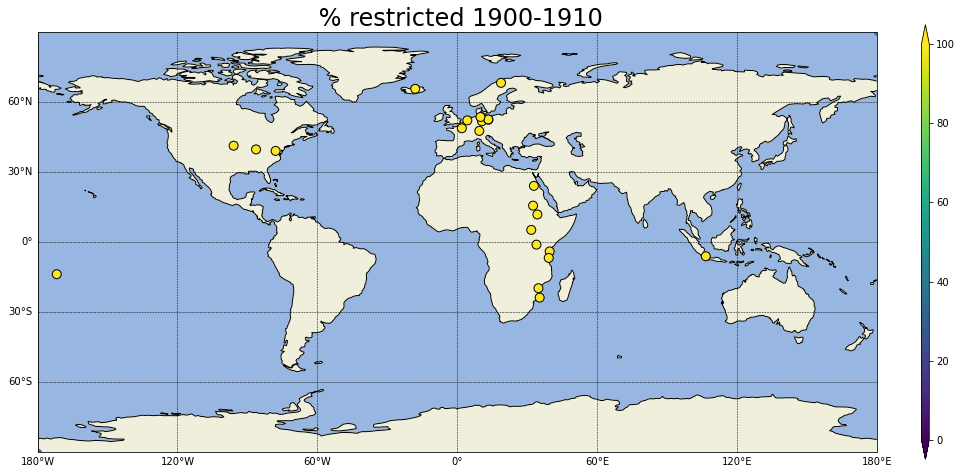

In [7]:
j = 0
lats = []
lons = []
proz = []
for i in b:
    if not isinstance(i[0], str):
        if ~np.isnan(i[0][4+(2*j)]):
            lats.append(i[0][0])
            lons.append(i[0][1])
            proz.append(i[0][4+(2*j)])
points(lons,lats,values=proz, showtitle='% restricted 1900-1910',)

<GeoAxesSubplot:title={'center':' % restricted 1910-1920'}>

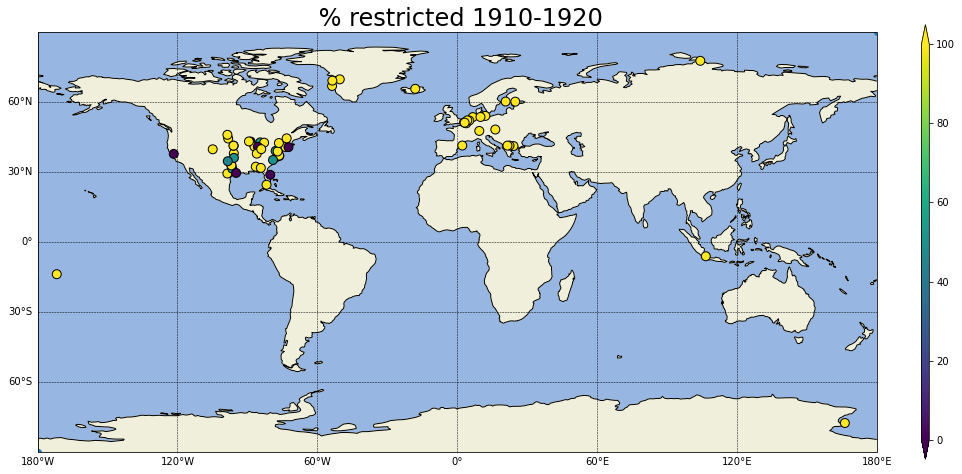

In [8]:
j = 1
lats = []
lons = []
proz = []
for i in b:
    if not isinstance(i[0], str):
        if ~np.isnan(i[0][4+(2*j)]):
            lats.append(i[0][0])
            lons.append(i[0][1])
            proz.append(i[0][4+(2*j)])
points(lons,lats,values=proz, showtitle='% restricted 1910-1920',)

<GeoAxesSubplot:title={'center':' % restricted 1920-1930'}>

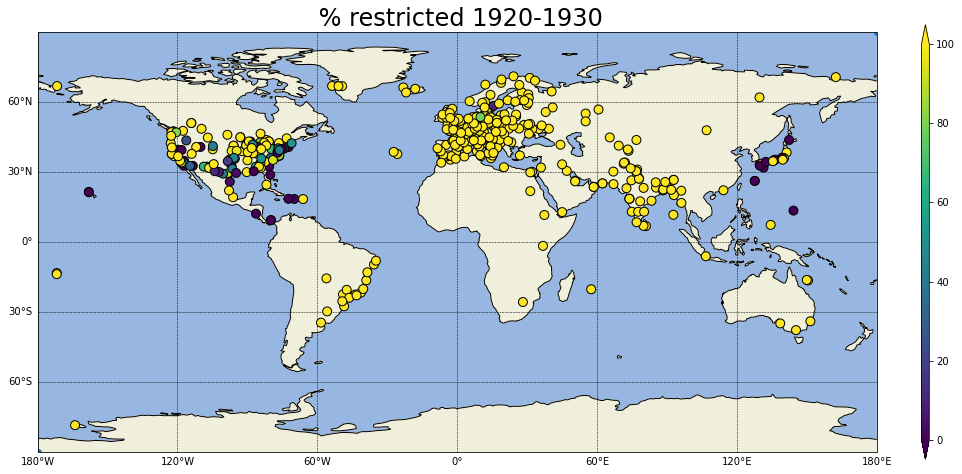

In [9]:
j = 2
lats = []
lons = []
proz = []
for i in b:
    if not isinstance(i[0], str):
        if ~np.isnan(i[0][4+(2*j)]):
            lats.append(i[0][0])
            lons.append(i[0][1])
            proz.append(i[0][4+(2*j)])
points(lons,lats,values=proz, showtitle='% restricted 1920-1930',)

<GeoAxesSubplot:title={'center':' % restricted 1930-1940'}>

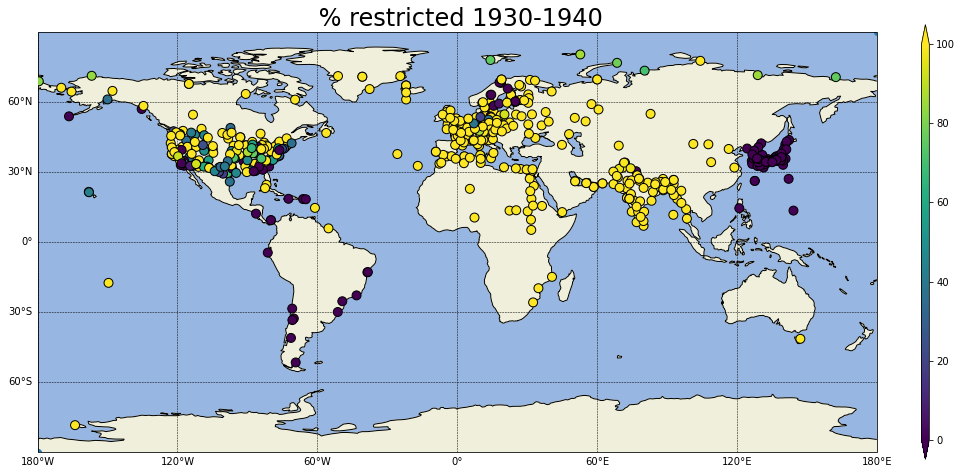

In [10]:
j = 3
lats = []
lons = []
proz = []
for i in b:
    if not isinstance(i[0], str):
        if ~np.isnan(i[0][4+(2*j)]):
            lats.append(i[0][0])
            lons.append(i[0][1])
            proz.append(i[0][4+(2*j)])
points(lons,lats,values=proz, showtitle='% restricted 1930-1940',)

<GeoAxesSubplot:title={'center':' % restricted 1940-1950'}>

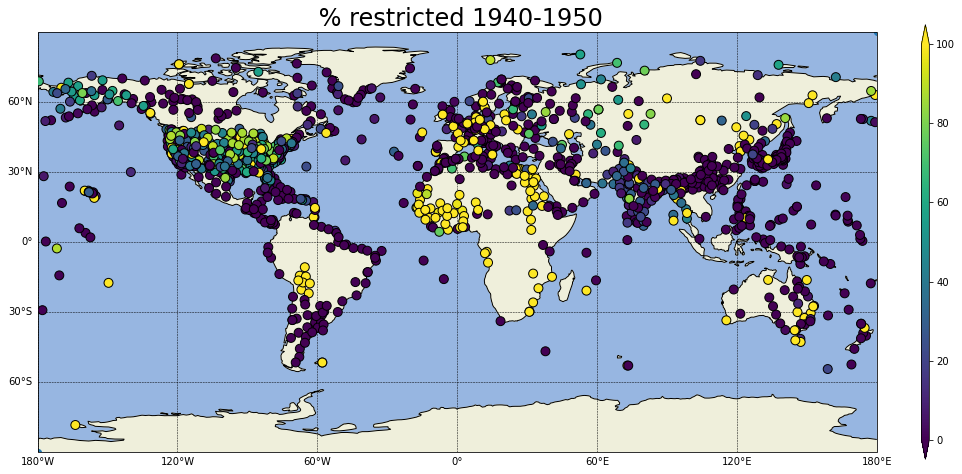

In [11]:
j = 4
lats = []
lons = []
proz = []
for i in b:
    if not isinstance(i[0], str):
        if ~np.isnan(i[0][4+(2*j)]):
            lats.append(i[0][0])
            lons.append(i[0][1])
            proz.append(i[0][4+(2*j)])
points(lons,lats,values=proz, showtitle='% restricted 1940-1950',)

<GeoAxesSubplot:title={'center':' % restricted 1950-1960'}>

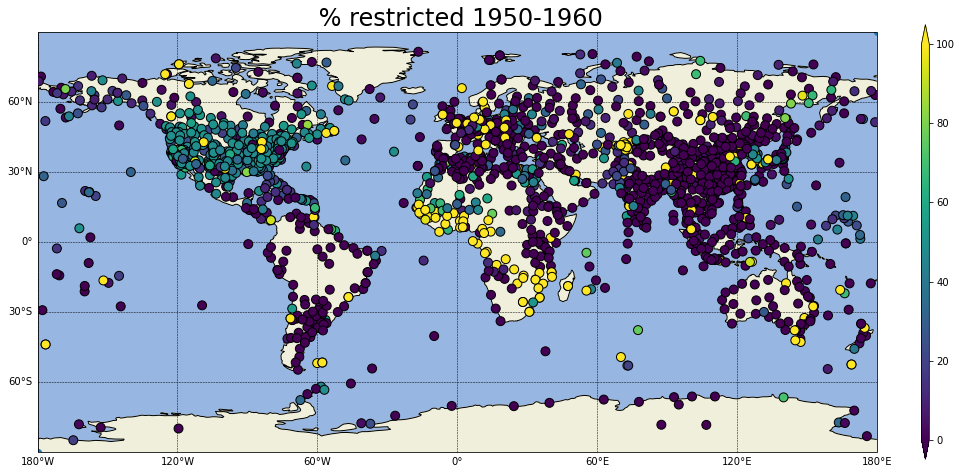

In [12]:
j = 5
lats = []
lons = []
proz = []
for i in b:
    if not isinstance(i[0], str):
        if ~np.isnan(i[0][4+(2*j)]):
            lats.append(i[0][0])
            lons.append(i[0][1])
            proz.append(i[0][4+(2*j)])
points(lons,lats,values=proz, showtitle='% restricted 1950-1960',)

<GeoAxesSubplot:title={'center':' % restricted 1960-1970'}>

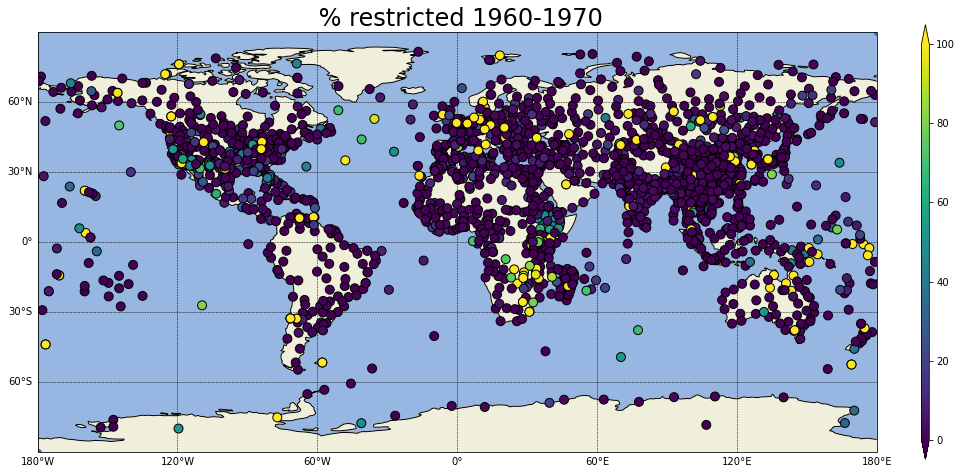

In [13]:
j = 6
lats = []
lons = []
proz = []
for i in b:
    if not isinstance(i[0], str):
        if ~np.isnan(i[0][4+(2*j)]):
            lats.append(i[0][0])
            lons.append(i[0][1])
            proz.append(i[0][4+(2*j)])
points(lons,lats,values=proz, showtitle='% restricted 1960-1970',)

<GeoAxesSubplot:title={'center':' % restricted 1970-1980'}>

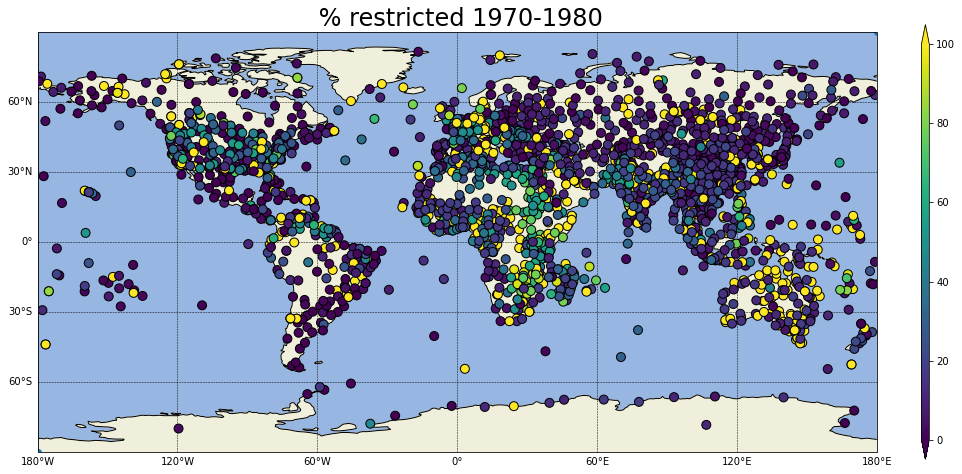

In [14]:
j = 7
lats = []
lons = []
proz = []
for i in b:
    if not isinstance(i[0], str):
        if ~np.isnan(i[0][4+(2*j)]):
            lats.append(i[0][0])
            lons.append(i[0][1])
            proz.append(i[0][4+(2*j)])
points(lons,lats,values=proz, showtitle='% restricted 1970-1980',)

<GeoAxesSubplot:title={'center':' % restricted 1980-1990'}>

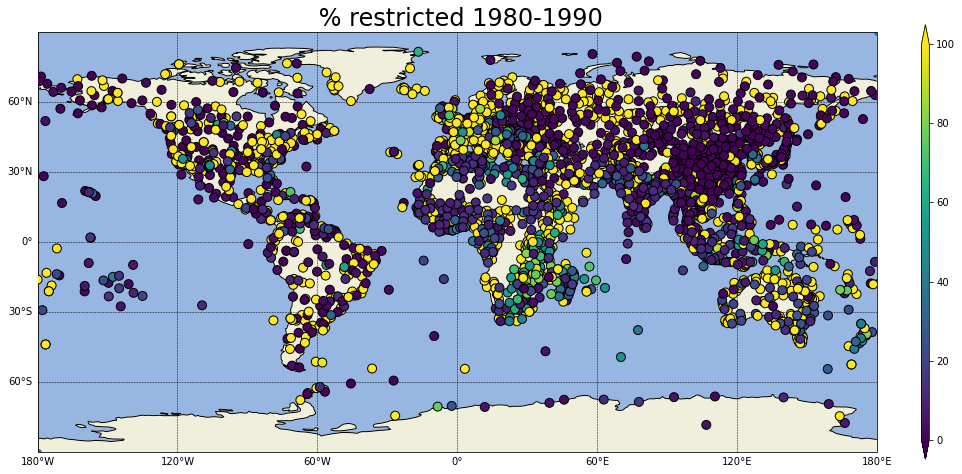

In [15]:
j = 8
lats = []
lons = []
proz = []
for i in b:
    if not isinstance(i[0], str):
        if ~np.isnan(i[0][4+(2*j)]):
            lats.append(i[0][0])
            lons.append(i[0][1])
            proz.append(i[0][4+(2*j)])
points(lons,lats,values=proz, showtitle='% restricted 1980-1990',)

<GeoAxesSubplot:title={'center':' % restricted 1990-2000'}>

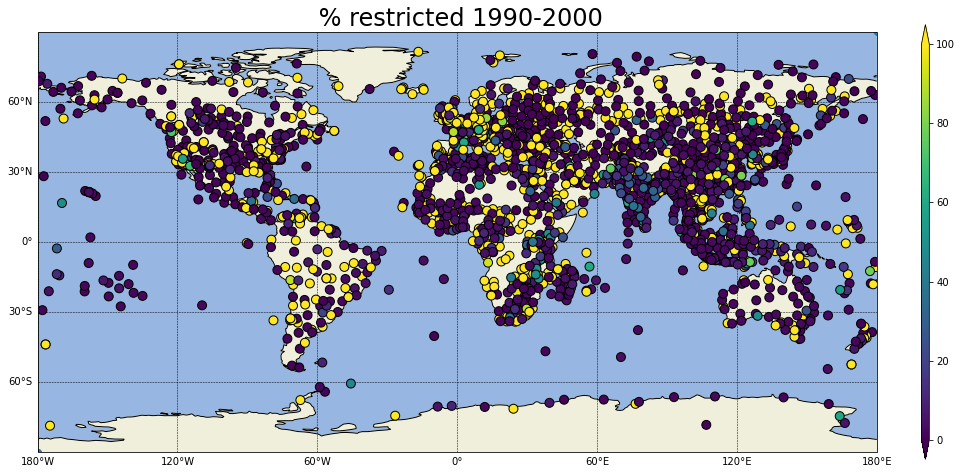

In [16]:
j = 9
lats = []
lons = []
proz = []
for i in b:
    if not isinstance(i[0], str):
        if ~np.isnan(i[0][4+(2*j)]):
            lats.append(i[0][0])
            lons.append(i[0][1])
            proz.append(i[0][4+(2*j)])
points(lons,lats,values=proz, showtitle='% restricted 1990-2000',)

<GeoAxesSubplot:title={'center':' % restricted 2000-2010'}>

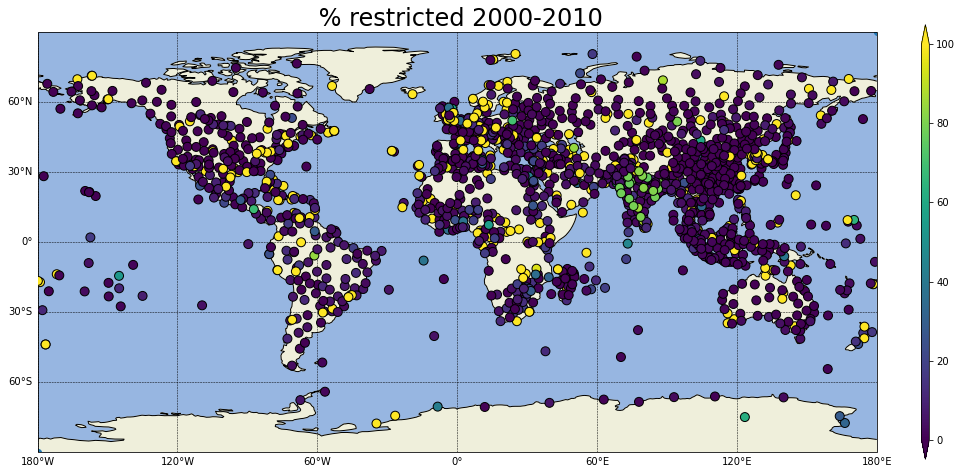

In [17]:
j = 10
lats = []
lons = []
proz = []
for i in b:
    if not isinstance(i[0], str):
        if ~np.isnan(i[0][4+(2*j)]):
            lats.append(i[0][0])
            lons.append(i[0][1])
            proz.append(i[0][4+(2*j)])
points(lons,lats,values=proz, showtitle='% restricted 2000-2010',)

<GeoAxesSubplot:title={'center':' % restricted 2010-2020'}>

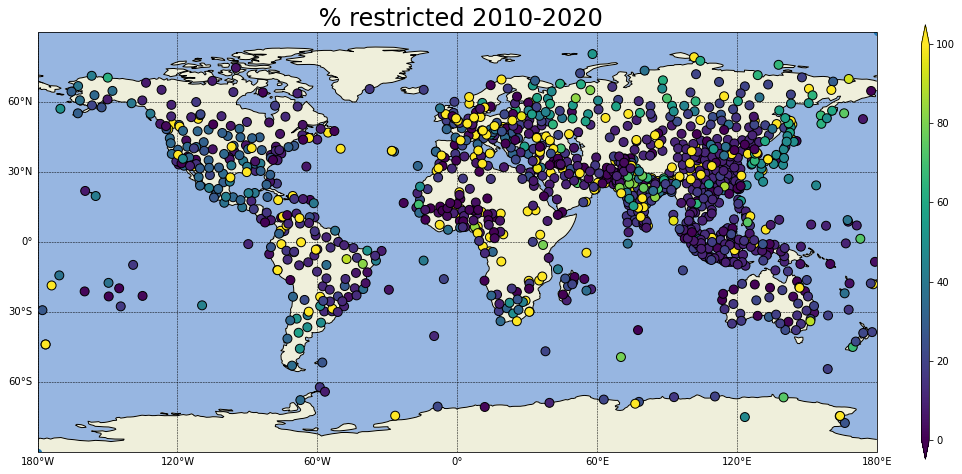

In [18]:
j = 11
lats = []
lons = []
proz = []
for i in b:
    if not isinstance(i[0], str):
        if ~np.isnan(i[0][4+(2*j)]):
            lats.append(i[0][0])
            lons.append(i[0][1])
            proz.append(i[0][4+(2*j)])
points(lons,lats,values=proz, showtitle='% restricted 2010-2020',)